In [198]:
import pandas as pd
df = pd.read_csv('diabetes.csv')

In [199]:
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
class DiabetesPredictor:
    def __init__(self, *args, **kwargs):
        self.df = pd.read_csv('diabetes.csv')
        self.tuner = kt.Hyperband(model_builder,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='redes_tp2_ej1')
    
    def separate_data_and_labels(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)

    def get_correlation(self):
        correlations = df.corr()
        return correlations['Outcome'].sort_values(ascending=False)
        ##aaa
    
    def replace_outliers(self):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        for col in self.df.columns:
            if (col!= "Outcome"):
                #Cálculo de parámetros para obtener los outliers.
                q1 = df[col].quantile(0.25)
                q3 = df[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                Lower_tail = q1 - 1.5 * iqr
                Upper_tail = q3 + 1.5 * iqr
                #Cálculo de la mediana.
                med = np.median(self.df[col])
                #Reemplazo.
                for i in self.df[col]:
                    if i > Upper_tail or i < Lower_tail:
                            self.df[col] = self.df[col].replace(i, med)

    def replace_nulls(self):
        columns = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
        self.df[columns] = self.df[columns].replace(0,np.NaN)
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def remove_cols(self, cols):
        self.df = self.df.drop(['SkinThickness', 'BloodPressure'], axis=1)
    
    def normalize_data(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std

    def split_train_test(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=5)
        #nbb

    def model_builder(hp):
        model = Sequential()
        model.add(Dense(1,activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Choice('learning_rate', values=[1.0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def find_best_hyperparams(self):
        self.tuner.search(self.x_train, self.y_train, epochs=50, validation_split=0.2)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def train_model(self, epochs):
        model = self.tuner.hypermodel.build(best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=50, validation_split=0.2)

        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)

        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=25, validation_split=0.2)
        #ifijf

    def make_predictions(self):
        preds = self.hypermodel.predict(self.x_test)
        self.predictions = np.rint(preds)
        #mfigm

    def plot_roc(self):
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_test, self.predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        #igig

    def get_metrics(self):
        print('Specificity: ' + str(specificity(self.y_test.astype(float), self.predictions.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_test.astype(float), self.predictions.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_test.astype(float), self.predictions.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_test.astype(float), self.predictions.astype(float))))
        #figjr
    

In [200]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [201]:
print(df.shape)

(768, 9)


In [202]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [203]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


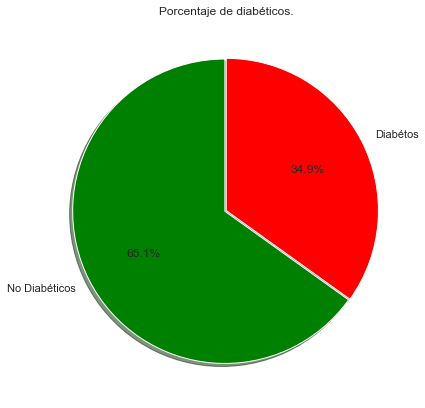

In [204]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [205]:
import numpy as np

df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.isnull().sum()

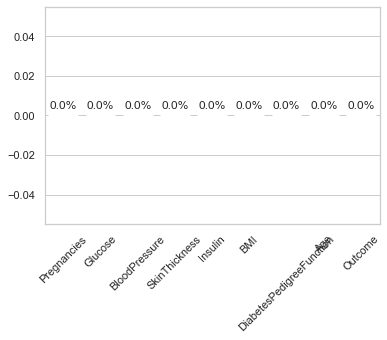

In [206]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df.columns, y=df.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [207]:
correlations = df.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [208]:
# df = df.drop(['SkinThickness', 'BloodPressure'], axis=1)
# df.head()

In [209]:
# column = ['Glucose','BMI']
# median=df[column].median()
# df[column]=df[column].replace(np.NaN,median)
# df.isnull().sum()

In [210]:
D = df[(df['Outcome'] != 0)]
H = df[(df['Outcome'] == 0)]

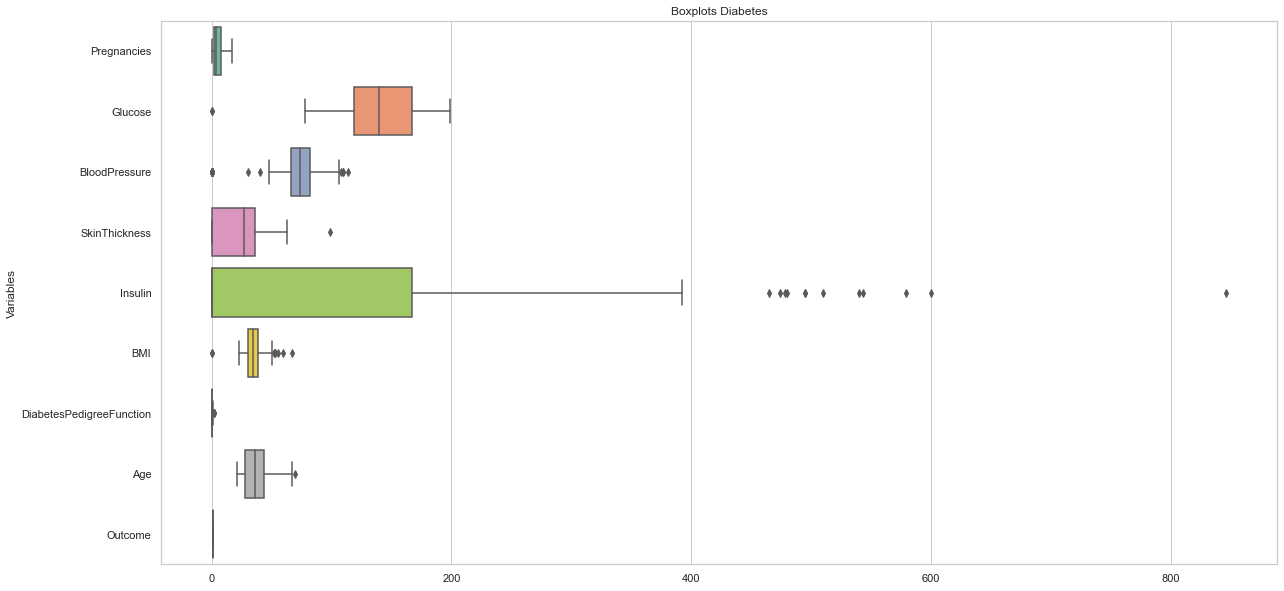

In [211]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots Diabetes")
ax = sns.boxplot(data = D, 
  orient = 'h', 
  palette = 'Set2')

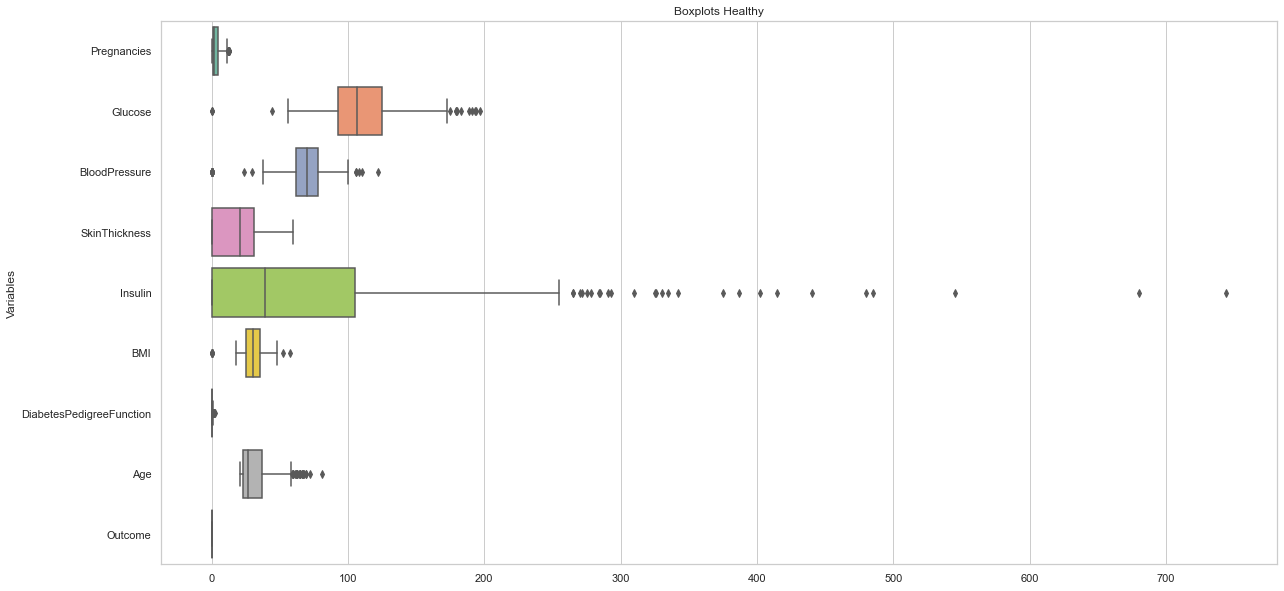

In [212]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots Healthy")
ax = sns.boxplot(data = H, 
  orient = 'h', 
  palette = 'Set2')

In [213]:
df_values = df.values
x = df_values[:,:-1]
y = df_values[:, -1].reshape(x.shape[0], 1)

In [214]:
# Mean, columnar axis.
x_mean = np.mean(x, axis=0, keepdims=True)

# Std. Deviation, columnar axis.
x_std = np.std(x, axis=0, keepdims=True)

# Normalizing.
x = (x - x_mean)/x_std

print(x[:5, :])

[[ 0.63994726  0.84832379  0.14964075  0.90726993 -0.69289057  0.20401277
   0.46849198  1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575  0.53090156 -0.69289057 -0.68442195
  -0.36506078 -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 -1.28821221 -0.69289057 -1.10325546
   0.60439732 -0.10558415]
 [-0.84488505 -0.99820778 -0.16054575  0.15453319  0.12330164 -0.49404308
  -0.92076261 -1.04154944]
 [-1.14185152  0.5040552  -1.50468724  0.90726993  0.76583594  1.4097456
   5.4849091  -0.0204964 ]]


In [215]:
from sklearn.model_selection import train_test_split

# Split the model into a 0.9-0.1 train-test split.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=5)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (691, 8)
Shape of y_train:  (691, 1)
Shape of x_test:  (77, 8)
Shape of y_test:  (77, 1)


In [216]:
import tensorflow as tf
from keras import backend as K

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [217]:
def plot_loss(model):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [218]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers

In [219]:
def model_builder(hp):
    model = Sequential()
    model.add(Dense(1,activation='sigmoid', input_shape=(x.shape[1],)))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
    hp_learning_rate = hp.Choice('learning_rate', values=[1.0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
    

    model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                    loss=keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.AUC()])

    return model

In [220]:
tuner = kt.Hyperband(model_builder,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='redes_tp2_ej1')

In [221]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2)
best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]

Trial 26 Complete [00h 00m 06s]
val_loss: 0.4989129900932312

Best val_loss So Far: 0.46646901965141296
Total elapsed time: 00h 02m 39s
INFO:tensorflow:Oracle triggered exit


In [222]:
print('Best Learning Rate: ' + str(best_hps.get('learning_rate')))
print('Best Momentum: ' + str(best_hps.get('momentum')))

Best Learning Rate: 0.1
Best Momentum: 0.9


In [223]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
18/18 [==============================] - 3s 65ms/step - loss: 0.6303 - auc: 0.7163 - val_loss: 0.4590 - val_auc: 0.8448
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4929 - auc: 0.8281 - val_loss: 0.4859 - val_auc: 0.8473
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.4932 - auc: 0.8261 - val_loss: 0.4600 - val_auc: 0.8523
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.4840 - auc: 0.8315 - val_loss: 0.4665 - val_auc: 0.8502
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4920 - auc: 0.8222 - val_loss: 0.4795 - val_auc: 0.8480
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4865 - auc: 0.8311 - val_loss: 0.4663 - val_auc: 0.8456
Epoch 7/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4968 - auc: 0.8185 - val_loss: 0.4610 - val_auc: 0.8525
Epoch 8/50
18/18 [==============================] - 0s 7ms/step - loss: 0.4894 - auc: 0.8

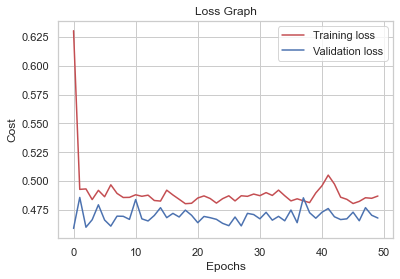

In [224]:
plot_loss(history)

In [225]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=25, validation_split=0.2)

Epoch 1/25
18/18 [==============================] - 2s 34ms/step - loss: 0.7220 - auc: 0.6147 - val_loss: 0.4800 - val_auc: 0.8455
Epoch 2/25
18/18 [==============================] - 0s 4ms/step - loss: 0.5124 - auc: 0.8325 - val_loss: 0.5041 - val_auc: 0.8355
Epoch 3/25
18/18 [==============================] - 0s 4ms/step - loss: 0.4931 - auc: 0.8293 - val_loss: 0.4567 - val_auc: 0.8505
Epoch 4/25
18/18 [==============================] - 0s 4ms/step - loss: 0.4848 - auc: 0.8305 - val_loss: 0.4691 - val_auc: 0.8500
Epoch 5/25
18/18 [==============================] - 0s 4ms/step - loss: 0.4951 - auc: 0.8274 - val_loss: 0.4734 - val_auc: 0.8473
Epoch 6/25
18/18 [==============================] - 0s 4ms/step - loss: 0.4902 - auc: 0.8270 - val_loss: 0.4739 - val_auc: 0.8437
Epoch 7/25
18/18 [==============================] - 0s 10ms/step - loss: 0.4926 - auc: 0.8209 - val_loss: 0.4667 - val_auc: 0.8509
Epoch 8/25
18/18 [==============================] - 0s 4ms/step - loss: 0.4832 - auc: 0.

In [226]:
predictions = hypermodel.predict(x_test)

In [227]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

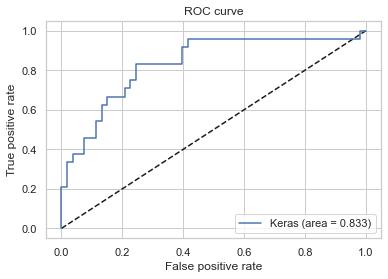

In [228]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [229]:
from sklearn.metrics import confusion_matrix
rounded_preds = np.rint(predictions)
confusion_matrix(y_test, rounded_preds)

array([[45,  8],
       [ 8, 16]], dtype=int64)

In [230]:
from sklearn.metrics import precision_score
rounded_preds = np.rint(predictions)

print('Specificity: ' + str(specificity(y_test.astype(float), rounded_preds.astype(float))))
print('Sensitivity: ' + str(sensitivity(y_test.astype(float), rounded_preds.astype(float))))
print('Positive Predictive Value: ' + str(positive_predictive_value(y_test.astype(float), rounded_preds.astype(float))))
print('Negative Predictive Value: ' + str(negative_predictive_value(y_test.astype(float), rounded_preds.astype(float))))

Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
